# Диффузионные модели

В этом ноутбуке мы попробуем рассмотреть и реализовать принцип работы дифузных моделей поэтапно.

Полезные ссылки:
* [Курс от HuggingFace](https://github.com/huggingface/diffusion-models-class)
* [Хорошее объяснение диффузионных моделей](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)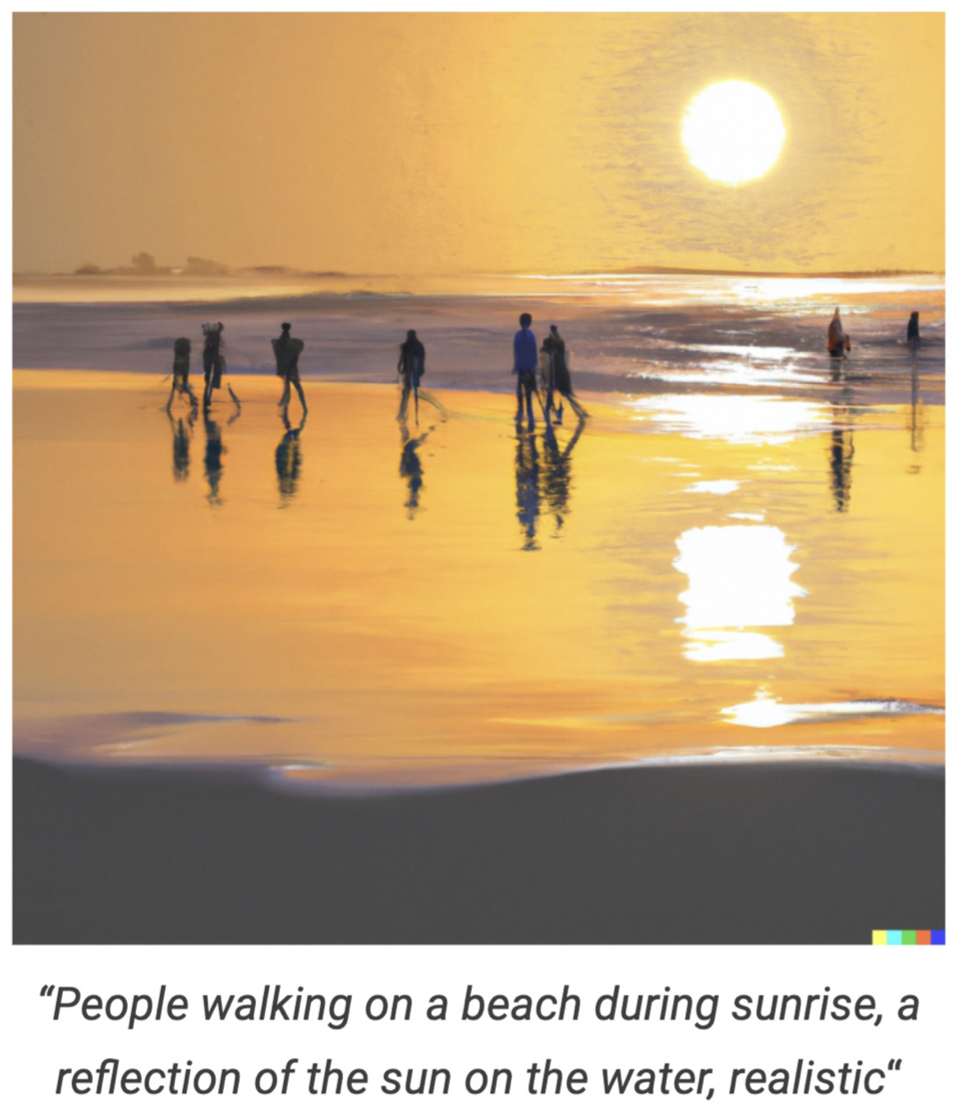


### План семинара:
1. Зашумляем данные
2. Обучаем простейшую диффузионную модель на MNIST
3. Генерируем новые изображения
4. Сравниваем простейшую диффузионную модель с Denoising Diffusion Probabilistic Models (DDPM)

In [ ]:
!pip install diffusers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.1 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Зашумляем данные

Будем работать с уже известным вам датасетом MNIST.

In [ ]:
dataset = torchvision.datasets.MNIST(
    root="mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 196884524.38it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 96368889.28it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69927416.27it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19242958.35it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys");

Представим, что мы хотим с какой-то долей зашумлять наши данные. В идеале — контролировать этот процесс. Как бы мы это делали?

Введем переменную `amount`, которая будет отвечать за количество зашумления и реализуем функцию `corrupt`, которая будет "смешивать" вход `x` со случайным шумом:


In [ ]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    """
    Corrupt the input `x` by mixing it with noise according to `amount`
    :param amount: torch.Tensor of shape [x.shape[1], x.shape[2], x.shape[3]]
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

Легко заметить, что при `amount=0` никакого зашумления не будет, а при `amount=1` мы полностью зашумим изначальную картинку. Смешивая входные данные с шумом с такими весами, мы сохраняем их в исходном диапазоне – от 0 до 1.

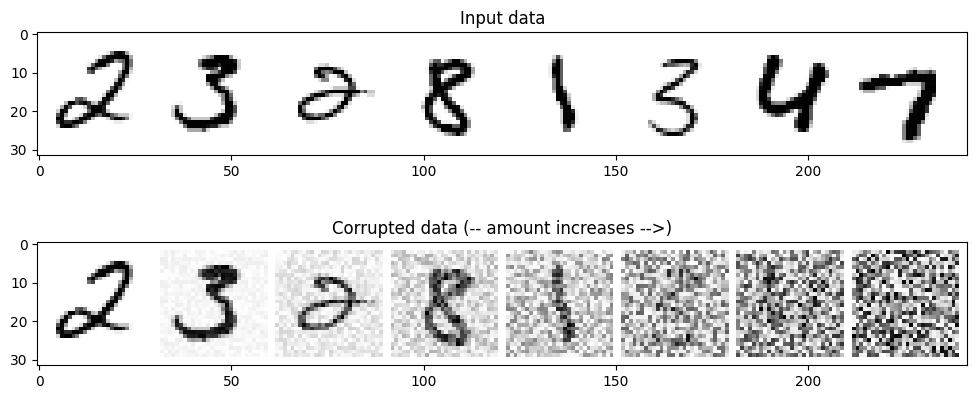

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys");

## 2. Обучаем простейшую диффузионную модель на MNIST
### Модель
Будем использовать (упрощенную) архитектуру UNet:

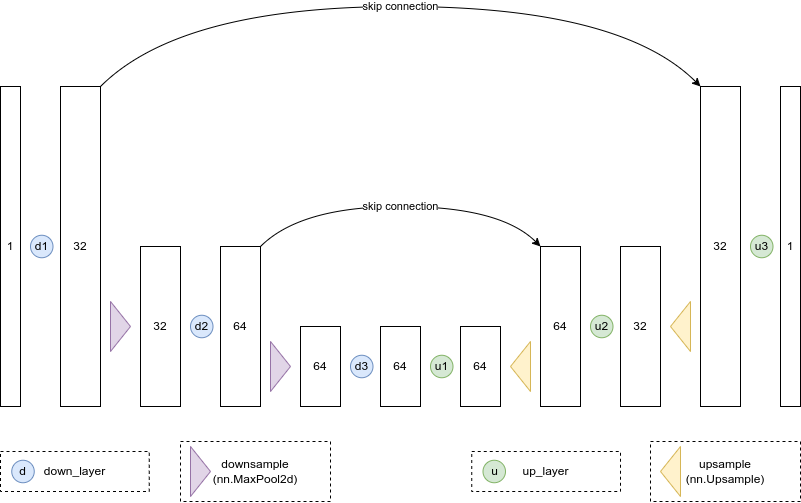

In [ ]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

Проверим размеры выходов сети и посмотрим на количество её параметров:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
assert net(x).shape == x.shape

print(f"Количество параметров в сети: {sum([p.numel() for p in net.parameters()])}")

Количество параметров в сети: 309057


### Обучение

Как будем обучать нашу модель? Потребуем, чтобы нейронная сеть восстаналивала исходную картинку после зашумления. Сравним полученный результат с исходной картинкой с помощью MSE по пикселям.

Finished epoch 0. Average loss for this epoch: 0.03
Finished epoch 1. Average loss for this epoch: 0.02
Finished epoch 2. Average loss for this epoch: 0.02


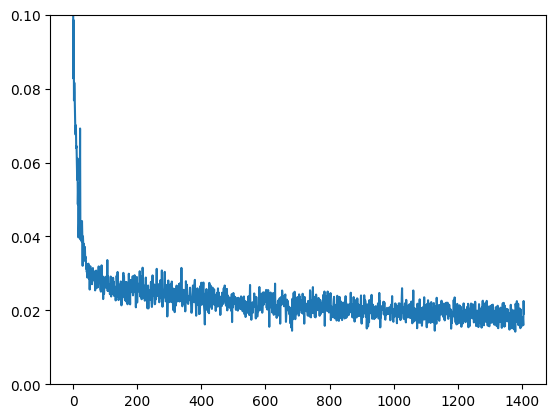

In [ ]:
n_epochs = 3
batch_size = 128

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)

        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.2f}")

plt.plot(losses)
plt.ylim(0, 0.1);

Давайте посмотрим на то, как модель справляется с шумом:

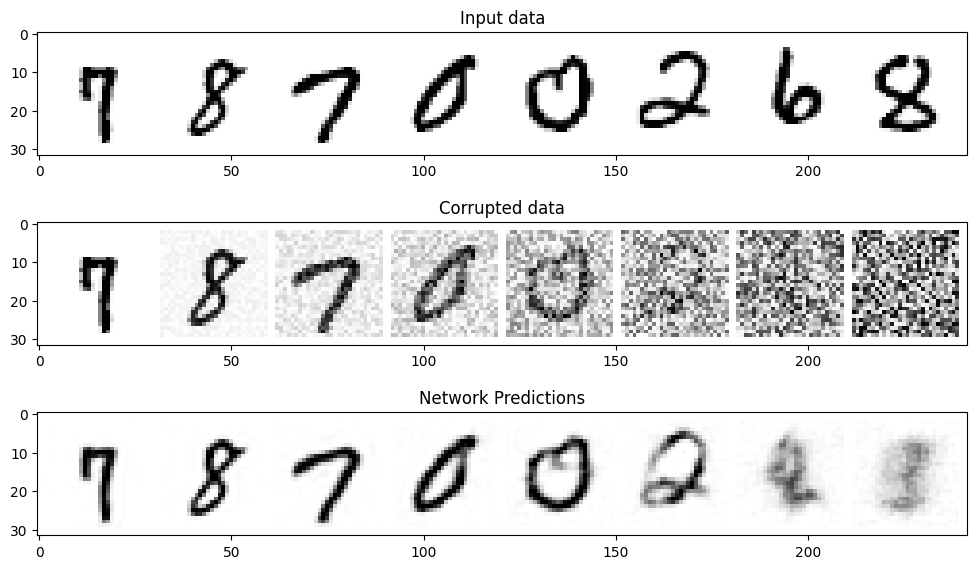

In [ ]:
x, y = next(iter(train_dataloader))
x = x[:8]

# Corrupt with a range of amounts (left to right -> more corruption)
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys");

Наблюдения:
1. Достаточно легко и быстро улавливает основные закономерности и до какого-то момента неплохо денойзит
2. При большой зашумленности получается что-то непонятное

## 3. Генерируем новые изображения

При сильной зашумленности предсказания модели получились не очень. Что делать в таком случае? Будем действовать поэтапно.

* Начнем со случайного шума
* Затем возьмём прогнозы модели и немного продвинемся к этому прогнозу, скажем, на `20%`. У нас получится очень зашумленное изображение, в котором, возможно, есть намек на структуру.
* Снова передадим это изображение в модель, чтобы получить новый прогноз. Мы надеемся, что этот новый прогноз будет немного лучше первого, потому что изображение зашумлено слабее.
* Делаем еще один небольшой шаг с этим новым, лучшим прогнозом. Повторим процедуру несколько раз, и (если все пойдет хорошо) мы получим изображение!

Ниже запустим этот процесс из 5 шагов.

*Обратите внимание: модель предсказывает изображение с шумоподавлением даже на шаге 1. Но далее мы используем взвешенную сумму исходной зашумленной картинки и предсказания модели. И так на каждом шаге, пока мы не получим окончательные результаты.*

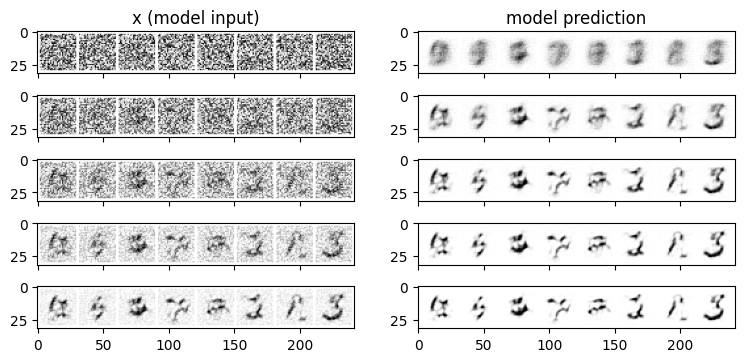

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys"
    )

Теперь давайте увеличим количество шагов до 40!
И посмотрим только на генерации:

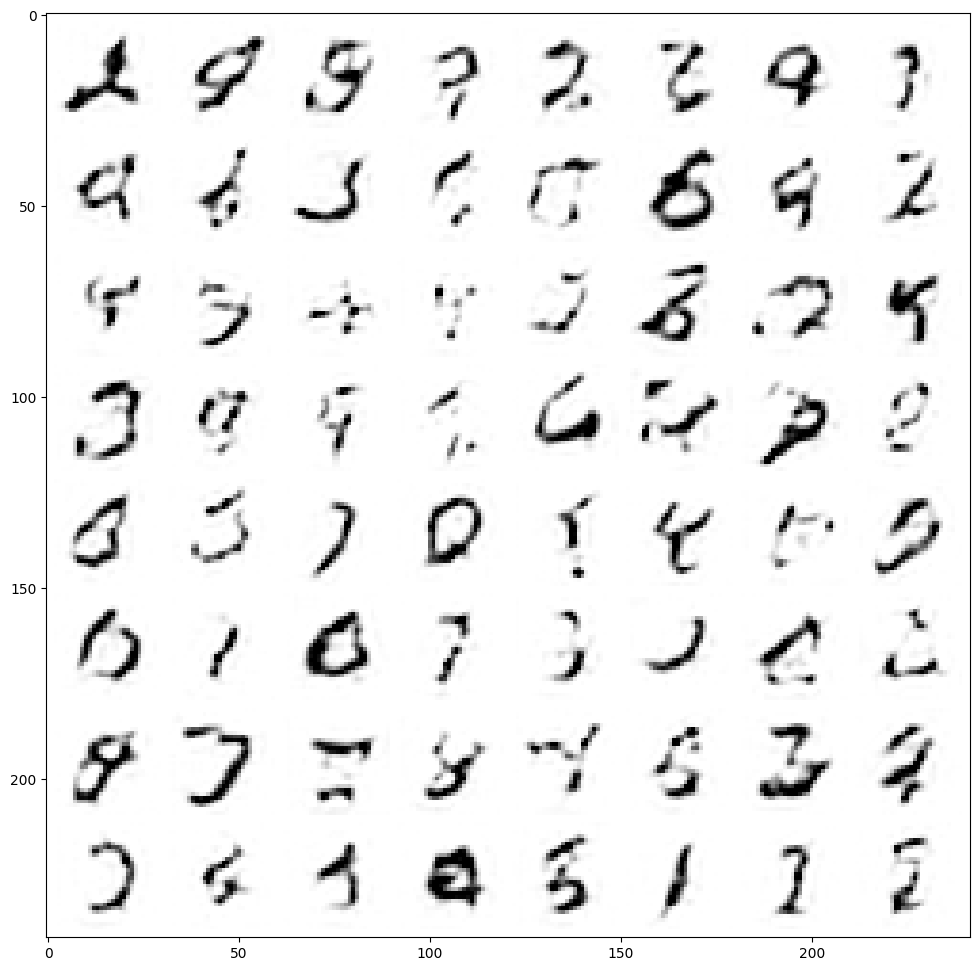

In [ ]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys"
);

Получилось уже относительно неплохо. Особенно если помнить, что мы взяли очень легкую модель + всего пару эпох обучения, которые завершились меньше, чем за минуту. Увеличив мощности, можно получить лучшие результаты.

## 4. Сравниваем простейшую диффузионную модель с Denoising Diffusion Probabilistic Models (DDPM)

Сравним нашу игрушечную имплементацию с статейной Denoising Diffusion Probabilistic Models (DDPM) ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)).

* В статье используется `UNet2DModel`. Она больше и хитрее, чем наша `BasicUNet`
* По-другому сделан процесс зашумления (corruption process)
* Другая цель обучения: модель прогнозирует сам шум, а не изображение до зашумления.
* В модели есть дополнительный параметр `t` (время), который передается на вход метода `forward`.
* Другие стратегии генерации новых изображений. Они должны работать лучше нашей упрощенной версии.

После выхода статьи о DDPM было предложено несколько улучшений, но мы надеемся, что и этот пример будет достаточно показательным. Советуем также [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364). В ней подробно рассматриваются идеи из оригинальной статьи и даются новые рекомендации о том, как добиться наилучшей производительности.

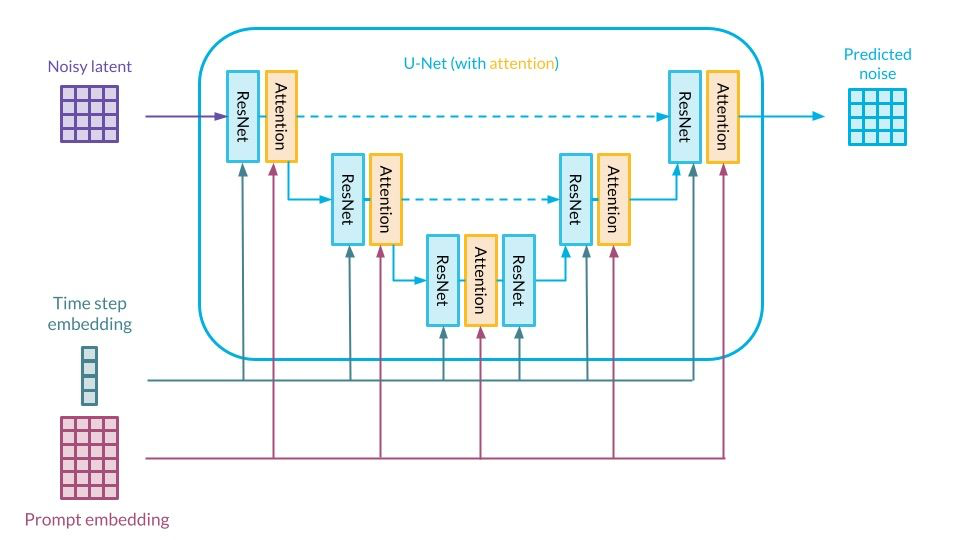

In [ ]:
net = UNet2DModel(
    sample_size=28,  # target image resolution
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # regular ResNet downsampling block
        "AttnDownBlock2D",  # ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # regular ResNet upsampling block
    ),
).to(device)

sum([p.numel() for p in net.parameters()])  # 1.7M vs ~309k parameters of the BasicUNet

1707009

Попробуем воспроизвести обучение простой модели из начала семинара, используя модель из статьи вместо нашей исходной. На каждом шаге в модель нужно передавать `x`, так и временной шаг. Здесь мы всегда передаём `t = 0`, чтобы показать, что она работает и без временного шага. Вы также можете попробовать ввести `(amount * 1000)`.

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average loss for this epoch: 0.019259


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average loss for this epoch: 0.013054


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average loss for this epoch: 0.011720


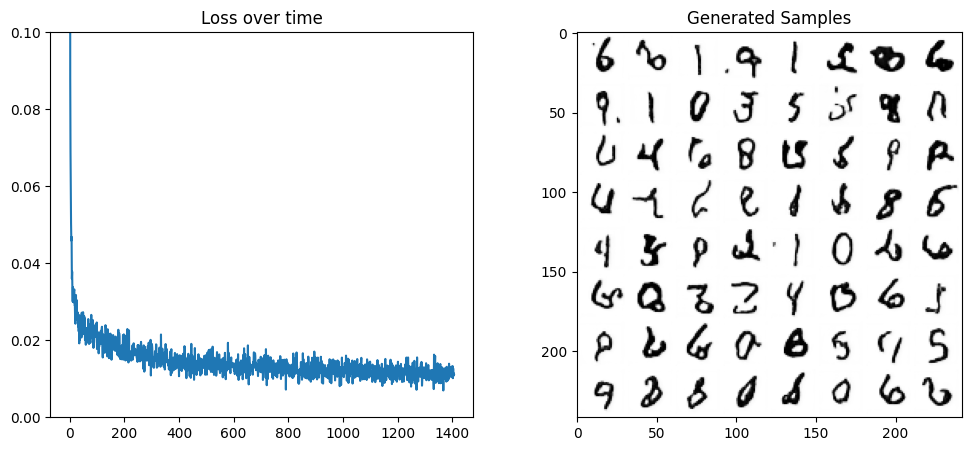

In [ ]:
n_epochs = 3
batch_size = 128

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # Get some data and prepare the corrupted version
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, 0).sample  # <<< Using timestep 0 always, adding .sample

        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys"
)
axs[1].set_title("Generated Samples");

Судя по лоссу, архитектура из статьи гораздо лучше справляется с расшумлением изображений!